In [227]:
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [228]:
train_df = pd.read_csv("Data/train.csv")
test_df = pd.read_csv("Data/test.csv")

In [229]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [230]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [231]:
train_df[train_df["keyword"] == "ablaze"][:10]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1
38,56,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1
39,57,ablaze,Paranaque City,Ablaze for you Lord :D,0
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0


### Text pre-processing

In [252]:
class TextPreprocessing():
    
    def __init__(self):
        self.nlp = spacy.load('en_core_web_md')
        
    def clean_text(self, col):
        clean_col = []
        for doc in col:
            # remove URL
            clean_doc = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', doc)
            # remove_punctutation
            clean_doc = re.sub(r"[^a-zA-Z0-9 ]", '', clean_doc)
            # remove_digit
            clean_doc = re.sub(r'\d+', '', clean_doc)
            # lowercasing_text
            clean_doc = clean_doc.lower()
            # remove extra space
            clean_doc = clean_doc.strip()
            clean_col.append(clean_doc)
        return clean_col
    
    def tokenize(self, col):
        return [doc.split() for doc in col]
    
    def lematize(self, col):
        # nlp = spacy.load('en_core_web_md')
        lemma_col = []
        for doc in col:
            spacy_doc = self.nlp(doc)
            lemma_col.append([token.lemma_ for token in spacy_doc])
        return lemma_col
    
    def remove_stop_word(self, token_col):
        wo_stop_word = [] 
        for doc in token_col:
            filtered_sentence =[]
            for word in doc:
                lexeme = self.nlp.vocab[word]
                if lexeme.is_stop == False:
                    filtered_sentence.append(word)
            wo_stop_word.append(filtered_sentence)
        return wo_stop_word
    
    def preprocess_(self, doc, col):
        docnew = doc
        preprocess = TextPreprocessing()
        docnew["clean_text"] = preprocess.clean_text(col)
        docnew["token"] = preprocess.tokenize(docnew["clean_text"])
        docnew["lema_text"] = preprocess.lematize(docnew["clean_text"])
        return docnew

In [256]:
tp = TextPreprocessing()
train_p = tp.preprocess_(train_df, train_df["text"])
test_p = tp.preprocess_(test_df, test_df["text"])

In [259]:
print(train_p.head())
print(test_p.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         clean_text  \
0       1  our deeds are the reason of this earthquake ma...   
1       1              forest fire near la ronge sask canada   
2       1  all residents asked to shelter in place are be...   
3       1  people receive wildfires evacuation orders in ...   
4       1  just got sent this photo from ruby alaska as s...   

                                               token  \
0  [our, deeds, are, the, reason, of, this, earth...   
1      [forest, fire, near, la, ronge, s

In [68]:
def word_frequency_plot(tokens):
    #counts the words, pairs and trigrams
    counted = Counter(tokens)
    counted_2= Counter(ngrams(tokens,2))
    counted_3= Counter(ngrams(tokens,3))
    #creates 3 data frames and returns thems
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
    trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
    # create subplot of the different data frames
    fig, axes = plt.subplots(3,1,figsize=(8,20))
    sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq.head(30))
    sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs.head(30))
    sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams.head(30))

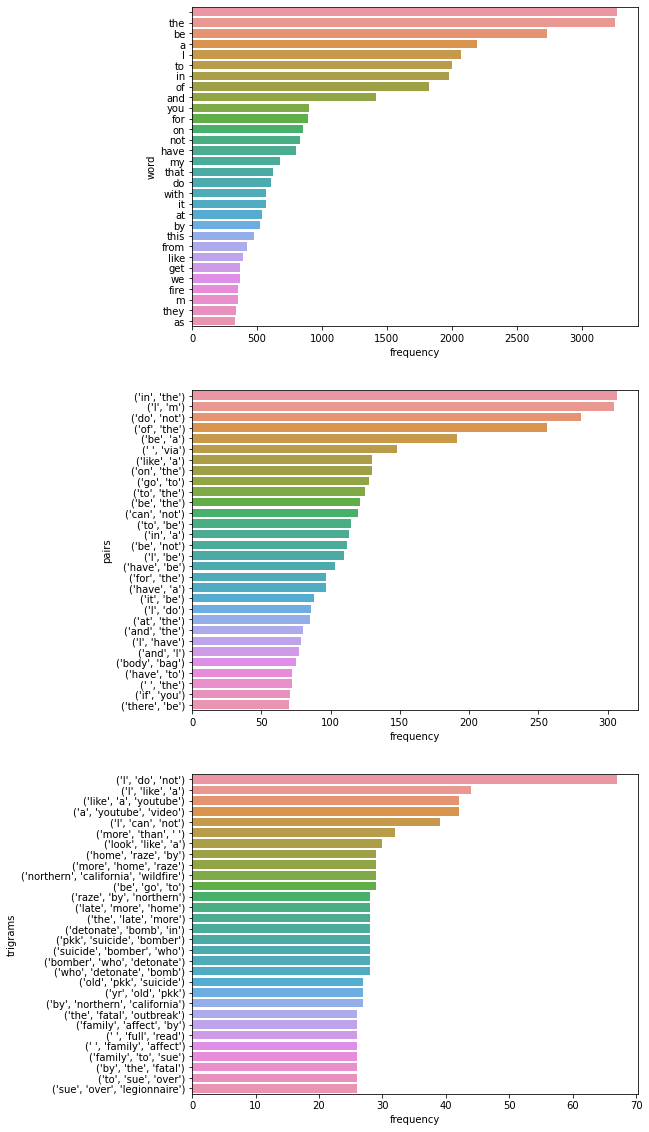

In [261]:
# most frequently occurring words
all_tokens = [token for token_set in train_p["lema_text"] for token in token_set]
word_frequency_plot(all_tokens)

#### Findings: Most frequently occurring words are stop words

In [265]:
train_p["no_stpwrd_clean_text"] = preprocess.remove_stop_word(train_p["token"])
test_p["no_stpwrd_clean_text"] = preprocess.remove_stop_word(test_p["token"])

In [266]:
train_p.head()

,id,keyword,location,text,target,clean_text,token,lema_text,no_stpwrd_clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth...","[our, deed, be, the, reason, of, this, earthqu...","[deeds, reason, earthquake, allah, forgive]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[all, resident, ask, to, shelter, in, place, b...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfire, evacuation, order,...","[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[just, got, send, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


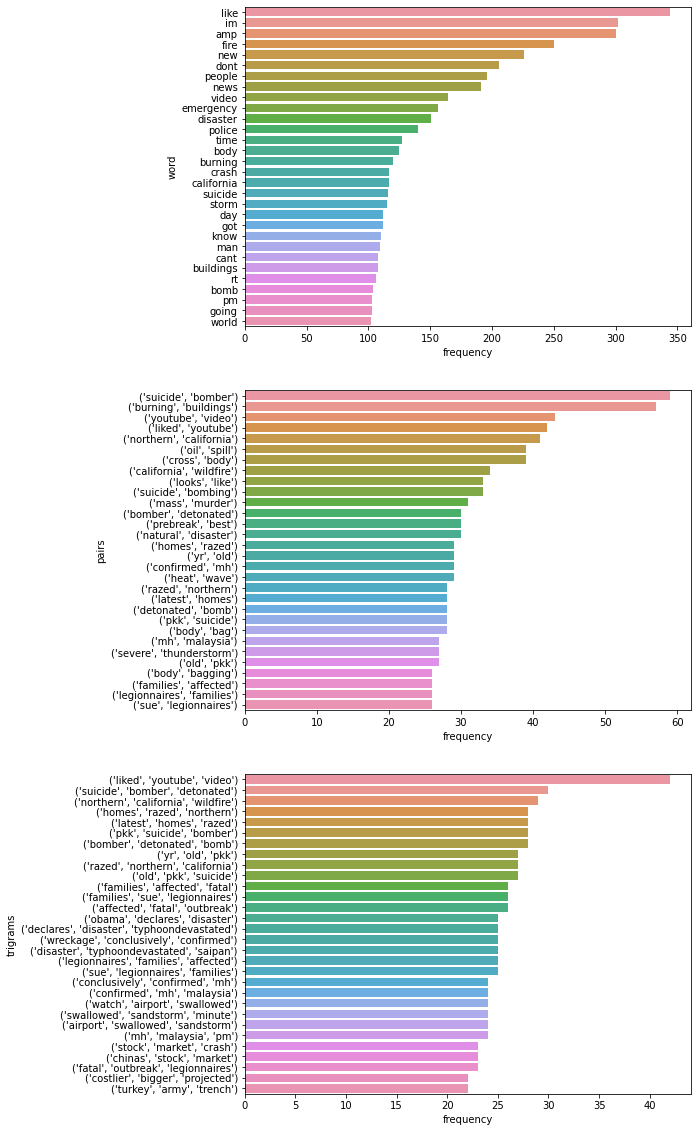

In [267]:
# most frequently occurring words in non-lematized text
all_tokens = [token for token_set in train_p["no_stpwrd_clean_text"] for token in token_set]
word_frequency_plot(all_tokens)

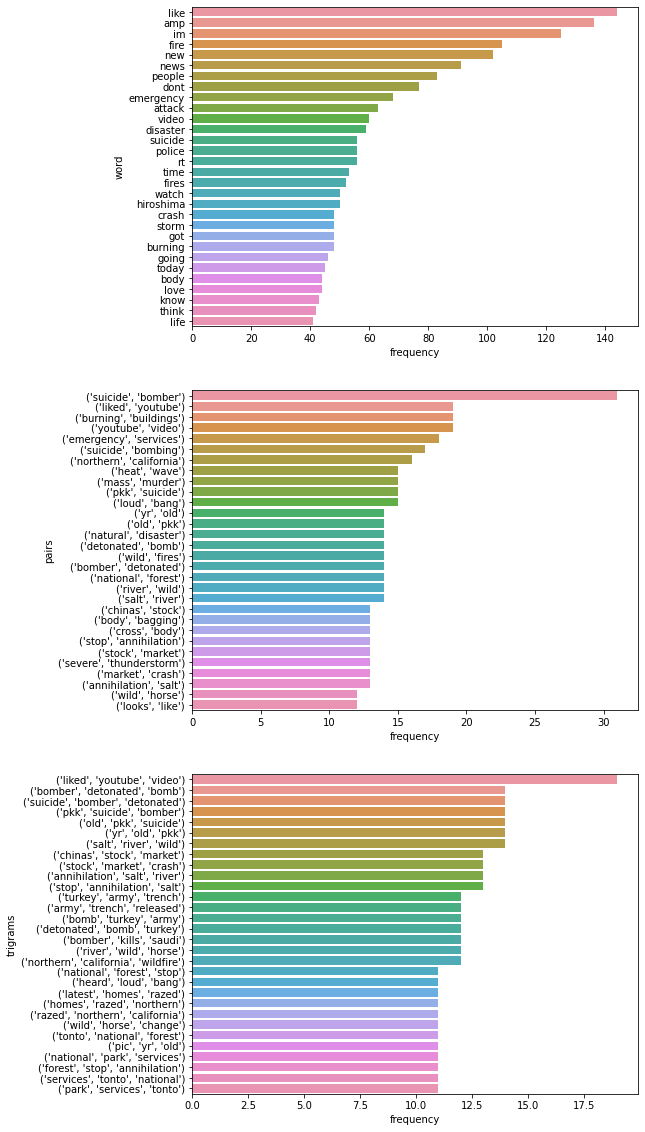

In [268]:
# most frequently occurring words in non-lematized text
all_tokens = [token for token_set in test_p["no_stpwrd_clean_text"] for token in token_set]
word_frequency_plot(all_tokens)

In [270]:
train_p['nostopwrd_text'] = [' '.join(doc) for doc in train_p["no_stpwrd_clean_text"]]
test_p['nostopwrd_text'] = [' '.join(doc) for doc in test_p["no_stpwrd_clean_text"]]

In [271]:
train_p.to_csv("Data/clean_train_data.csv", index=False)
test_p.to_csv("Data/clean_test_data.csv", index=False)

## Vectorization: TF-IDF

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [272]:
train_vec_df = pd.read_csv("Data/clean_train_data.csv")
test_vec_df = pd.read_csv("Data/clean_test_data.csv")

In [273]:
train_vec_df.head()

,id,keyword,location,text,target,clean_text,token,lema_text,no_stpwrd_clean_text,nostopwrd_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"['our', 'deeds', 'are', 'the', 'reason', 'of',...","['our', 'deed', 'be', 'the', 'reason', 'of', '...","['deeds', 'reason', 'earthquake', 'allah', 'fo...",deeds reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"['forest', 'fire', 'near', 'la', 'ronge', 'sas...","['forest', 'fire', 'near', 'la', 'ronge', 'sas...","['forest', 'fire', 'near', 'la', 'ronge', 'sas...",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"['all', 'residents', 'asked', 'to', 'shelter',...","['all', 'resident', 'ask', 'to', 'shelter', 'i...","['residents', 'asked', 'shelter', 'place', 'no...",residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,"['people', 'receive', 'wildfires', 'evacuation...","['people', 'receive', 'wildfire', 'evacuation'...","['people', 'receive', 'wildfires', 'evacuation...",people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"['just', 'got', 'sent', 'this', 'photo', 'from...","['just', 'got', 'send', 'this', 'photo', 'from...","['got', 'sent', 'photo', 'ruby', 'alaska', 'sm...",got sent photo ruby alaska smoke wildfires pou...


In [276]:
print(train_vec_df[train_vec_df["nostopwrd_text"].isnull()])
print(test_vec_df[test_vec_df["nostopwrd_text"].isnull()])

Empty DataFrame
Columns: [id, keyword, location, text, target, clean_text, token, lema_text, no_stpwrd_clean_text, nostopwrd_text]
Index: []
    id keyword location       text clean_text           token       lema_text  \
13  43     NaN      NaN  What if?!    what if  ['what', 'if']  ['what', 'if']   

   no_stpwrd_clean_text nostopwrd_text  
13                   []            NaN  


#### Remove the NaN record

In [277]:
test_vec_df2 = test_vec_df.drop([13])

In [278]:
test_vec_df2[test_vec_df2["nostopwrd_text"].isnull()]

,id,keyword,location,text,clean_text,token,lema_text,no_stpwrd_clean_text,nostopwrd_text


#### feature creation

In [324]:
vectorizer_train = TfidfVectorizer()
vec_trn = vectorizer_train.fit_transform(train_vec_df["nostopwrd_text"])
vectorizer_test = TfidfVectorizer()
vec_tst = vectorizer_test.fit_transform(test_vec_df2["nostopwrd_text"])

In [325]:
print(vec_trn)

  (0, 5630)	0.5086703925575171
  (0, 402)	0.4454479442014707
  (0, 4521)	0.352828731444906
  (0, 12030)	0.39949578063406976
  (0, 3738)	0.5086703925575171
  (1, 2186)	0.3929522783047347
  (1, 12870)	0.48742314067292003
  (1, 12587)	0.48742314067292003
  (1, 8268)	0.3501958268043662
  (1, 10024)	0.3136495084953657
  (1, 5420)	0.23678918426791187
  (1, 5619)	0.30552188427569454
  (2, 5039)	0.24486843054874569
  (2, 10650)	0.25469993530578555
  (2, 4950)	0.20661880842727062
  (2, 10455)	0.2685566629955072
  (2, 10288)	0.31593312788903016
  (2, 11222)	0.45655250338095077
  (2, 13261)	0.5567763355050941
  (2, 841)	0.2645314400628254
  (2, 12302)	0.2685566629955072
  (3, 2138)	0.31334177074671976
  (3, 16329)	0.4497149749940795
  (3, 12051)	0.5333659806345767
  (3, 11020)	0.28241296371308483
  :	:
  (7609, 5437)	0.25414017973889585
  (7609, 2138)	0.24701384655551942
  (7610, 15757)	0.6498778827619599
  (7610, 6567)	0.5730000326556588
  (7610, 15978)	0.4993292501681094
  (7611, 7377)	0.205747

In [328]:
train_vec_df.head()

,id,keyword,location,text,target,clean_text,token,lema_text,no_stpwrd_clean_text,nostopwrd_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"['our', 'deeds', 'are', 'the', 'reason', 'of',...","['our', 'deed', 'be', 'the', 'reason', 'of', '...","['deeds', 'reason', 'earthquake', 'allah', 'fo...",deeds reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"['forest', 'fire', 'near', 'la', 'ronge', 'sas...","['forest', 'fire', 'near', 'la', 'ronge', 'sas...","['forest', 'fire', 'near', 'la', 'ronge', 'sas...",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"['all', 'residents', 'asked', 'to', 'shelter',...","['all', 'resident', 'ask', 'to', 'shelter', 'i...","['residents', 'asked', 'shelter', 'place', 'no...",residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,"['people', 'receive', 'wildfires', 'evacuation...","['people', 'receive', 'wildfire', 'evacuation'...","['people', 'receive', 'wildfires', 'evacuation...",people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"['just', 'got', 'sent', 'this', 'photo', 'from...","['just', 'got', 'send', 'this', 'photo', 'from...","['got', 'sent', 'photo', 'ruby', 'alaska', 'sm...",got sent photo ruby alaska smoke wildfires pou...


In [329]:
print(vec_trn.shape)
print(train_vec_df["id"].shape)

(7613, 16812)
(7613,)


In [331]:
tfidf_df = pd.DataFrame(vec_trn.toarray(), index=list(train_vec_df["id"]), columns=vectorizer_train.get_feature_names())

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Note:
Test set does not have labels, which means we cannot measure model performance on test set. Thus we will use train set as train-test set.

In [332]:
X_train = vec_trn.toarray()
y_train = train_vec_df["target"].to_numpy()
X_test = vec_tst.toarray()

In [333]:
print("X_train shape: {}; y_train shape: {}; X_test shape: {}".format(X_train.shape, y_train.shape, X_test.shape))

X_train shape: (7613, 16812); y_train shape: (7613,); X_test shape: (3262, 9888)


In [334]:
from sklearn.model_selection import train_test_split

In [348]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.2, random_state=189) # random state: random state of sampling

In [349]:
print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

(6090, 16812)
(1523, 16812)
(6090,)
(1523,)


In [359]:
from collections import Counter
print(Counter(y_train2))
print(Counter(y_test2))
print("ratio of target classes in train set(0/1): ", Counter(y_train2)[0]/Counter(y_train2)[1])
print("ratio of target classes in test set(0/1): ", Counter(y_test2)[0]/Counter(y_test2)[1])

Counter({0: 3458, 1: 2632})
Counter({0: 884, 1: 639})
ratio of target classes in train set(0/1):  1.3138297872340425
ratio of target classes in test set(0/1):  1.3834115805946792


Cool, almost balanced set!

## Model training - Multinomial Naive Bayes

In [350]:
from sklearn.naive_bayes import MultinomialNB

### Hold-out validation approach

In [351]:
clf = MultinomialNB()
model = clf.fit(X_train2, y_train2)
result = model.score(X_test2, y_test2)
print(result) 

0.8108995403808273


In [340]:
pred = model.predict(X_test2)
print(pred)

[0 0 0 ... 1 0 1]


### K-fold cross validation

In [362]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [369]:
clf2 = MultinomialNB()
kfold_val = KFold(50)
result = cross_val_score(clf2, X_train2, y_train2, cv=kfold_val, verbose=2)
print(result)
print("mean accuracy: ", np.mean(result))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   1.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.6s finished
